In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os

In [2]:
#halo_df = np.array( pd.read_csv( os.path.join("..","CorrelationAverages", "Old", "all_halo_omega_radial_AS.csv") ) ).T
halo_df = np.array( pd.read_csv( os.path.join("data", "static_halos_all_galaxy_omega_radial_AS.csv") ) ).T
galaxy_df = np.array( pd.read_csv( os.path.join("data", "all_galaxy_omega_radial_AS.csv") ) ).T
halo_cov = np.cov( halo_df )
galaxy_cov = np.cov( galaxy_df )

halo_corr = np.array( halo_cov )
galaxy_corr = np.array( galaxy_cov )
for i in range( len( halo_corr ) ):
    for j in range( len( halo_corr ) ):
        halo_corr[i,j] = halo_cov[i,j] / np.sqrt( halo_cov[i,i] * halo_cov[j,j] )
        galaxy_corr[i,j] = galaxy_cov[i,j] / np.sqrt( galaxy_cov[i,i] * galaxy_cov[j,j] )

In [4]:
halo_df.shape

(19, 200)

In [6]:
galaxy_cov = np.cov( halo_df[:10,:] )
galaxy_cov.shape

(10, 10)

In [3]:
sqrt_halo_cov_diag = np.sqrt( np.diagonal( halo_cov ) )
sqrt_galaxy_cov_diag = np.sqrt( np.diagonal( galaxy_cov ) )
sqrt_halo_corr_diag = np.sqrt( np.diagonal( halo_corr ) )
sqrt_galaxy_corr_diag = np.sqrt( np.diagonal( galaxy_corr ) )

In [4]:
rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

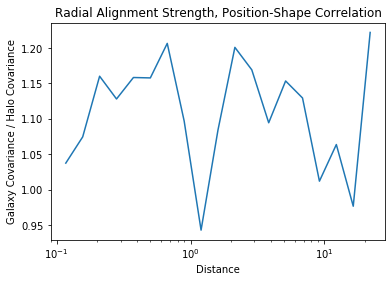

In [5]:
plt.plot( rbin_centers, sqrt_galaxy_cov_diag/sqrt_halo_cov_diag )
plt.title( "Radial Alignment Strength, Position-Shape Correlation" )
plt.ylabel( "Galaxy Covariance / Halo Covariance" )
plt.xlabel( "Distance" )
plt.xscale("log")

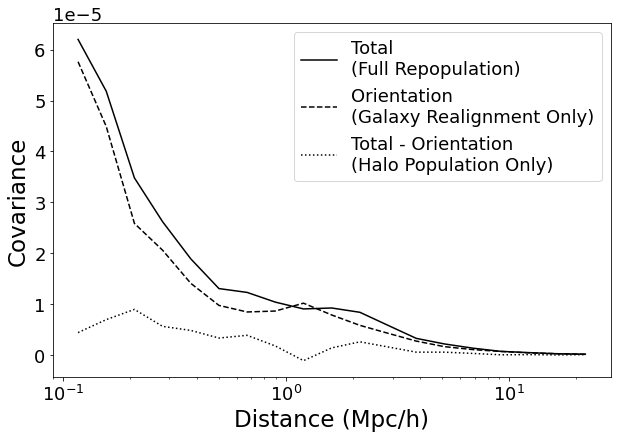

In [27]:
plt.rcParams["figure.figsize"] = [10.0, 6.5]
plt.rcParams["axes.labelsize"] = 23
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 18

plt.plot(rbin_centers, np.diagonal( galaxy_cov ), color="k", ls="-", label="Total\n(Full Repopulation)" )
plt.plot(rbin_centers, np.diagonal( halo_cov ), color="k", ls="--", label="Orientation\n(Galaxy Realignment Only)" )
plt.plot(rbin_centers, np.diagonal( galaxy_cov )-np.diagonal( halo_cov ), color="k", ls=":", label="Total - Orientation\n(Halo Population Only)" )
plt.legend()
plt.xscale("log")
plt.xlabel("Distance (Mpc/h)")
plt.ylabel("Covariance")

plt.savefig("covariance_comparison.pdf")

Text(0.5, 0, 'Distance Bin')

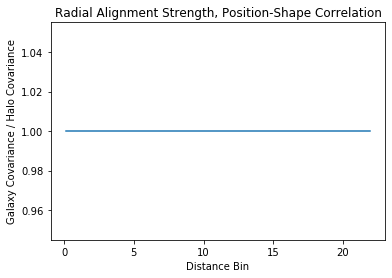

In [6]:
plt.plot( rbin_centers, sqrt_galaxy_corr_diag/sqrt_halo_corr_diag )
plt.title( "Radial Alignment Strength, Position-Shape Correlation" )
plt.ylabel( "Galaxy Covariance / Halo Covariance" )
plt.xlabel( "Distance Bin" )

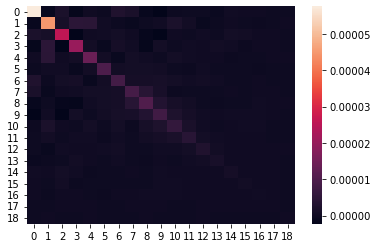

In [3]:
sb.heatmap( halo_cov )

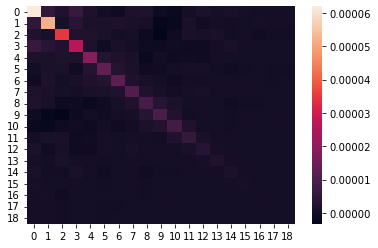

In [4]:
sb.heatmap( galaxy_cov )

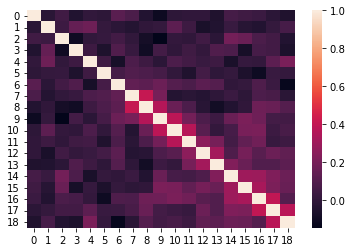

In [6]:
sb.heatmap( halo_corr )

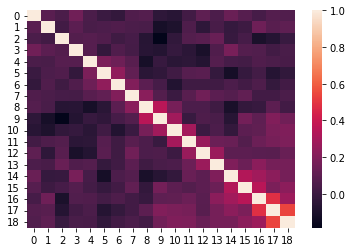

In [7]:
sb.heatmap( galaxy_corr )

In [4]:
halo_df.shape

(19, 200)

In [5]:
halo_cov.shape

(19, 19)

# Three Cov. Comparison

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, ZuMandelbaum15Cens, ZuMandelbaum15Sats, \
                                        Leauthaud11Cens, Leauthaud11Sats, Zheng07Cens, Zheng07Sats, \
                                        NFWPhaseSpace, SubhaloPhaseSpace
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace, Tinker13Cens, Tinker13QuiescentSats, \
                                        TrivialProfile, Tinker13ActiveSats
from halotools_ia.ia_models.ia_model_components import CentralAlignment, RandomAlignment, RadialSatelliteAlignment, \
                                                        HybridSatelliteAlignment, MajorAxisSatelliteAlignment, SatelliteAlignment, \
                                                        SubhaloAlignment
from halotools_ia.ia_models.ia_strength_models import RadialSatelliteAlignmentStrengthAlternate

from halotools_ia.correlation_functions import ed_3d, ee_3d

from halotools.utils import crossmatch

from halotools.sim_manager import HaloTableCache
from halotools.sim_manager import CachedHaloCatalog

from intrinsic_alignments.utils.jackknife_observables import jackknife_ed_3d, jackknife_ee_3d

In [11]:
def get_coords_and_orientations(model_inst):
    sat_cut = model_inst.mock.galaxy_table[ model_inst.mock.galaxy_table["gal_type"] == "satellites" ]
    cen_cut = model_inst.mock.galaxy_table[ model_inst.mock.galaxy_table["gal_type"] == "centrals" ]


    galaxy_coords_sat = np.array( [ sat_cut['x'],
                                    sat_cut['y'],
                                    sat_cut['z'] ] ).T
    galaxy_orientations_sat = np.array( [ sat_cut['galaxy_axisA_x'],
                                        sat_cut['galaxy_axisA_y'],
                                        sat_cut['galaxy_axisA_z'] ] ).T

    galaxy_coords_cen = np.array( [ cen_cut['x'],
                                    cen_cut['y'],
                                    cen_cut['z'] ] ).T
    galaxy_orientations_cen = np.array( [ cen_cut['galaxy_axisA_x'],
                                        cen_cut['galaxy_axisA_y'],
                                        cen_cut['galaxy_axisA_z'] ] ).T
    
    return galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, galaxy_orientations_cen

# Eliminate halos with 0 for halo_axisA_x(,y,z)
def mask_bad_halocat(halocat):
    bad_mask = (halocat.halo_table["halo_axisA_x"] == 0) & (halocat.halo_table["halo_axisA_y"] == 0) & (halocat.halo_table["halo_axisA_z"] == 0)
    halocat._halo_table = halocat.halo_table[ ~bad_mask ]

In [7]:
cache = HaloTableCache()
for entry in cache.log: print(entry)

#halocat = CachedHaloCatalog(simname='multidark', redshift=0)
halocat = CachedHaloCatalog(simname='bolplanck', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')
mask_bad_halocat(halocat)

('bolplanck', 'rockstar', 'halotools_v0p4', '-0.0023', 'C:\Users\nvana\.astropy\cache\halotools\halo_catalogs\bolplanck\rockstar\hlist_1.00231.list.halotools_v0p4.hdf5')
('bolshoi', 'rockstar', 'halotools_v0p4', '-0.0003', 'C:\Users\nvana\.astropy\cache\halotools\halo_catalogs\bolshoi\rockstar\hlist_1.00035.list.halotools_v0p4.hdf5')


## Make the model

In [15]:
rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

# MODELS
cens_occ_model = Leauthaud11Cens
cens_prof_model = TrivialPhaseSpace
cens_orientation = CentralAlignment
sats_occ_model = Leauthaud11Sats
sats_prof_model1 = SubhaloPhaseSpace
prof_args1 = ("satellites", np.logspace(10.5, 15.2, 15))
#sats_orientation1 = SubhaloAlignment(satellite_alignment_strength=0.5, halocat=halocat)
sats_orientation1 = RadialSatelliteAlignment(halocat=halocat)
#sats_orientation1 = SubhaloAlignment
sats_strength = RadialSatelliteAlignmentStrengthAlternate()
Lbox = halocat.Lbox
sats_strength.inherit_halocat_properties(Lbox=Lbox)
sats_orientation1.inherit_halocat_properties(Lbox=Lbox)

central_alignment = 1

In [16]:
# Initially create the mock with SubhaloAlignment to overwrite the host information with subhalo
model_instance = HodModelFactory(centrals_occupation = cens_occ_model(),
                                     centrals_profile = cens_prof_model(),
                                     satellites_occupation = sats_occ_model(),
                                     satellites_profile = sats_prof_model1(*prof_args1),
                                     satellites_radial_alignment_strength = sats_strength,
                                     centrals_orientation = cens_orientation(central_alignment_strength=central_alignment),
                                     satellites_orientation = sats_orientation1,
                                     model_feature_calling_sequence = (
                                     'centrals_occupation',
                                     'centrals_profile',
                                     'satellites_occupation',
                                     'satellites_profile',
                                     'satellites_radial_alignment_strength',
                                     'centrals_orientation',
                                     'satellites_orientation')
                                    )

model_instance.populate_mock(halocat)

c:\users\nvana\appdata\local\programs\python\python38-32\lib\site-packages\halotools\empirical_models\factories\hod_model_factory.py:741: UserWarning: 

The param_dict key smhm_delta_0 appears in more than one component model.
This is permissible, but if you are seeing this message you should be sure you understand it.
In particular, double-check that this parameter does not have conflicting meanings across components.

If you do not wish to see this message every time you instantiate, 
simply attach a _suppress_repeated_param_warning attribute 
to any of your component models and set this variable to ``True``.

  warn(msg % key)
c:\users\nvana\appdata\local\programs\python\python38-32\lib\site-packages\halotools\empirical_models\factories\hod_model_factory.py:741: UserWarning: 

The param_dict key smhm_m0_a appears in more than one component model.
This is permissible, but if you are seeing this message you should be sure you understand it.
In particular, double-check that this parame

## Get the Jackknife covariance

In [18]:
galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, galaxy_orientations_cen = \
                                                                            get_coords_and_orientations(model_instance)

ed, jackknife_cov = jackknife_ed_3d( galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, 
                             rbins, period=halocat.Lbox, Nsub=[4,4,4], verbose=True)

estimated time to complete jackknife calculation (s): 30.872940063476562


## Get covariance from just realigning galaxies (64x, as many as 4x4x4 jackknife)

In [19]:
runs = 64
realign_corr = []

for i in range(runs):
    model_instance._input_model_dictionary["satellites_orientation"].assign_satellite_orientation( table=model_instance.mock.galaxy_table )
    
    galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, galaxy_orientations_cen = \
                                                                            get_coords_and_orientations(model_instance)
    
    galaxy_sat_shape_cen_pos_omega = ed_3d( galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, rbins, period=halocat.Lbox )
    
    realign_corr.append( galaxy_sat_shape_cen_pos_omega )

c:\users\nvana\desktop\northeastern\research\halotools_ia\halotools_ia\ia_models\ia_model_components.py:513: UserWarning: 36838 galaxies have a radial distance equal to zero (or infinity) from their host. These galaxies will be re-assigned random alignment vectors.
  warn(msg)


In [24]:
realign_cov = np.cov( np.array( realign_corr ).T )

## Get covariance from full repopulation (64x, as many as 4x4x4 jackknife)

In [26]:
runs = 64
repop_corr = []

for i in range(runs):
    model_instance.mock.populate()
    galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, galaxy_orientations_cen = \
                                                                            get_coords_and_orientations(model_instance)
    
    galaxy_sat_shape_cen_pos_omega = ed_3d( galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, rbins, period=halocat.Lbox )
    
    repop_corr.append( galaxy_sat_shape_cen_pos_omega )

c:\users\nvana\desktop\northeastern\research\halotools_ia\halotools_ia\ia_models\ia_model_components.py:191: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
c:\users\nvana\desktop\northeastern\research\halotools_ia\halotools_ia\ia_models\ia_model_components.py:191: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
c:\users\nvana\desktop\northeastern\research\halotools_ia\halotools_ia\ia_models\ia_model_components.py:191: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
c:\users\nvana\desktop\northeastern\research\halotools_ia\halotools_ia\ia_models\ia_model_components.py:191: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
c:\users\nvana\desktop\northeastern\research\halotools_ia\halotools_ia\ia_models\ia_model_components.py:191: Use

In [27]:
repop_cov = np.cov( np.array( repop_corr ).T )

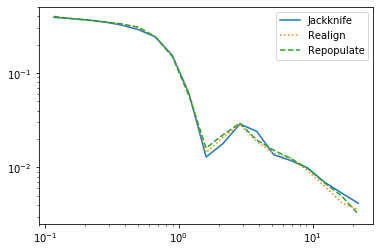

In [37]:
realign_corr = np.array(realign_corr)
realign_means = np.mean( realign_corr, axis=0 )

repop_corr = np.array(repop_corr)
repop_means = np.mean( repop_corr, axis=0 )

plt.plot( rbin_centers, ed, "-", label="Jackknife" )
plt.plot( rbin_centers, realign_means, ":", label="Realign" )
plt.plot( rbin_centers, repop_means, "--", label="Repopulate" )
plt.xscale("log")
plt.yscale("log")
plt.legend()

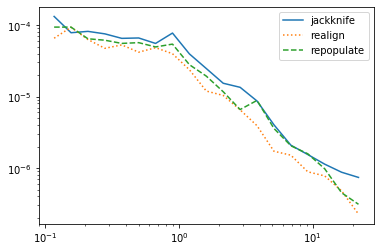

In [39]:
plt.plot( rbin_centers, np.diagonal( jackknife_cov ), "-", label="jackknife" )
plt.plot( rbin_centers, np.diagonal( realign_cov ), ":", label="realign" )
plt.plot( rbin_centers, np.diagonal( repop_cov ), "--", label="repopulate" )
plt.xscale("log")
plt.yscale("log")
plt.legend()

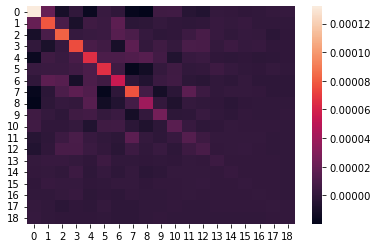

In [42]:
sb.heatmap( jackknife_cov )

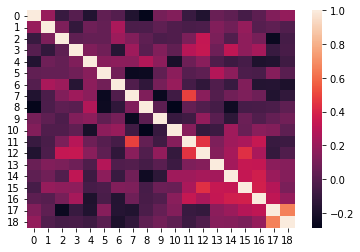

In [44]:
sb.heatmap( ( jackknife_cov / np.sqrt( np.diagonal(jackknife_cov) ) ).T / np.sqrt( np.diagonal(jackknife_cov) ) )

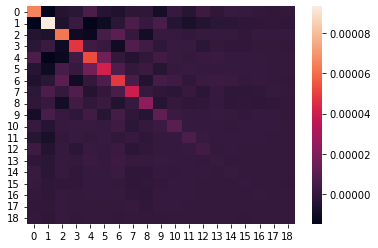

In [45]:
sb.heatmap( realign_cov )

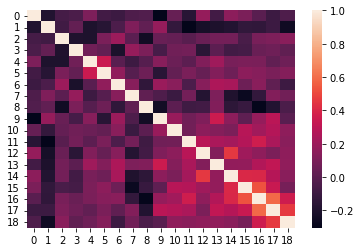

In [46]:
sb.heatmap( ( realign_cov / np.sqrt( np.diagonal(realign_cov) ) ).T / np.sqrt( np.diagonal(realign_cov) ) )

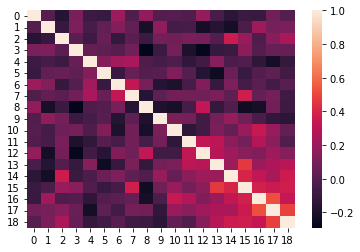

In [47]:
sb.heatmap( ( repop_cov / np.sqrt( np.diagonal(repop_cov) ) ).T / np.sqrt( np.diagonal(repop_cov) ) )